### wls_estimator.ipynb
- Siep Dokter
- Emil Jousimaa
- Oleksandr Sosovskyy
- Mario Gabriele Carofano

> This file contains the implementation of the WLS estimator, used for estimate the Target Coordinates starting from the RSS information coming from the anchors.

In [126]:
# IMPORTS
import import_ipynb
import constants
import auxfunc
import pandas as pd
import numpy as np
import pprint
import math
import matplotlib.pyplot as plot

In [127]:
def calculate_target_anchors_distance(anchor_dataframe):
    """
    Calculates the distance between the target and the anchors using the Euclidean norm.
    This is the implementation of (1) on the reference paper.

    Parameters:
    anchor_dataframe (DataFrame): A DataFrame-object containing the dataset of one anchor.

    Returns:
    target_anchors_distance (list): Returns a list of distances between the target and the anchor.
    """

    anchor_coords = [eval(i) for i in anchor_dataframe["Relative Coordinates [m]"][0].split(", ")]
    target_coords = [eval(i) for i in anchor_dataframe["Target Coordinates [m]"][0].split(", ")]
    target_anchors_distance = math.dist(anchor_coords, target_coords)

    return target_anchors_distance

# https://www.w3schools.com/python/ref_math_dist.asp
# https://www.w3schools.com/python/ref_string_split.asp
# https://www.geeksforgeeks.org/python-converting-all-strings-in-list-to-integers/

In [128]:
def calculate_target_anchors_estimation(average_RSS):
    """
    Calculates the distance estimates between each anchor and the target.
    This is the implementation of (4) on the reference paper.

    Parameters:
    average_RSS (list): A list which values are the average_RSS over a burst of 'constants.BURST_SIZE' consecutive measurements.

    Returns:
    estimated_distances (list): Returns a list which values are the distance estimations.
    """
    
    estimated_distances = []
    index = 0
    
    for mean in average_RSS:
        num = mean - constants.REFERENCE_POWER
        den = -10 * constants.PATH_LOSS_EXPONENT
        estimated_distances.append(round(10**(num/den), 3))
        index = index + 1

    return estimated_distances

In [129]:
def calculate_A_matrix(n_anchors, local_anchor_coords):

    # Build matrix A
    A = np.zeros((n_anchors, 3))  # 3 columns for -2x, -2y, 1

    for i in range(n_anchors):
        A[i, 0] = -2 * local_anchor_coords[i][0]
        A[i, 1] = -2 * local_anchor_coords[i][1]
        A[i, 2] = 1

    return A

In [130]:
def calculate_b_vector(n_anchors, local_anchor_coords, local_estimated_distances):
    """
    Calculates the 'b' vector of the system of equations which the WLS method solves.
    This is the implementation of (5) on the reference paper.

    Parameters:
    n_anchors (int): An integer which value represents the number of anchors in dataset.
    local_anchor_coords (list) : A list containing one list for each anchor, e.g. the 2D-coordinates of each anchor.
    local_estimated_distances (list) : A list containing one real number for each anchor, e.g. the distance estimation between each anchor and the target.

    Returns:
    b (numpy.ndarray): Returns a 1D numpy.ndarray which values are elements of the 'b' vector for the selected configuration.
    """
    
    norm_coords = []
    b = []

    for i in range(n_anchors):
        sqr_distance = math.pow(local_estimated_distances[i], 2)
        norm_coords.append(np.linalg.norm(local_anchor_coords))
        sqr_coords = math.pow(norm_coords[i], 2)
        diff = sqr_distance - sqr_coords
        b.append(round(diff, 3))
        i = i + 1
    
    return np.array(b)

# https://www.digitalocean.com/community/tutorials/norm-of-vector-python
# https://numpy.org/doc/stable/reference/generated/numpy.append.html

In [131]:
def calculate_W_matrix(n_anchors, local_estimated_distances):
    """
    Calculates, for the selected configuration, the 'W' diagonal matrix.
    The elements are the inverse of the variance of the square of the estimated distance.
    This is the implementation of [11, eq. (14)].

    Parameters:
    n_anchors (int): An integer which value represents the number of anchors in dataset.
    local_estimated_distances (list) : A list containing one real number for each anchor, e.g. the distance estimation between each anchor and the target.

    Returns:
    W (numpy.ndarray): Returns a 2D numpy.ndarray which values are elements of the 'W' diagonal matrix for the selected configuration.
    """

    num = math.pow(constants.STANDARD_DEVIATION, 2)
    den = 4.715 * math.pow(constants.PATH_LOSS_EXPONENT, 2)
    exp_value = math.exp(num/den)
    var_inverse = []

    for i in range(n_anchors):
        e4_distance = math.pow(local_estimated_distances[i], 4)
        var = e4_distance * exp_value * (exp_value-1)
        var_inverse.append(round(math.pow(var, -1), 3))

    return np.diag(var_inverse)
    
# https://www.w3schools.com/python/ref_math_exp.asp
# https://numpy.org/doc/stable/reference/generated/numpy.diag.html

In [132]:
def calculate_WLS_output(A, W, b):
    """
    Calculate the Weighted Least Squares (WLS) position estimate.
    This is the implementation of (6) on the reference paper.

    Parameters:
    A (numpy.ndarray): Matrix A.
    W (numpy.ndarray): Weight matrix W.
    b (numpy.ndarray): Vector b.

    Returns:
    position (numpy.ndarray): WLS position estimate.
    """
    
    A_transpose = np.transpose(A)
    
    # Calculate (A^T * W * A)^(-1) * A^T * W * b
    left_term = np.linalg.inv(np.matmul(np.matmul(A_transpose, W), A))
    right_term = np.matmul(np.matmul(A_transpose, W), b)

    # Calculate the final result
    position = np.matmul(left_term, right_term)

    return position

# https://numpy.org/doc/stable/reference/generated/numpy.matmul.html

In [82]:
def apply_WLS_hybrid_estimator(scenario_directory_path):
    # Concatenates the blt and wifi estimations
    
    dataframes_blt = {}
    dataframes_wifi = {}
    data = {}; data["Actual"] = {}; data["Estimated"] = {};
    
    directory_path = scenario_directory_path + "RPI/RSS_BLT_Dataset/"
    anchors_blt = auxfunc.get_anchors_name(directory_path)
    for a in anchors_blt:
        dataframes_blt[a] = pd.read_csv(directory_path + a, sep=constants.CSV_FIELDS_SEPARATOR)
        
    directory_path = scenario_directory_path + "RPI/RSS_WiFi_Dataset/"
    anchors_wifi = auxfunc.get_anchors_name(directory_path)
    for a in anchors_wifi:
        dataframes_wifi[a] = pd.read_csv(directory_path + a, sep=constants.CSV_FIELDS_SEPARATOR)
        
    length_blt = auxfunc.calculate_smallest_dataset(dataframes_blt)
    length_wifi = auxfunc.calculate_smallest_dataset(dataframes_wifi)
    length = length_blt if length_blt < length_wifi else length_wifi
    
    burst_quantity = auxfunc.calculate_burst_quantity(length)
    n_anchors = len(anchors_blt) + len(anchors_wifi)
    
    data["Actual"]["Target Coordinates"] = [eval(i) for i in dataframes_blt[a]["Target Coordinates [m]"][0].split(", ")]
    data["Actual"]["Distance Target - Anchor"] = []
    data["Actual"]["Anchor Coordinates"] = []
    for a in anchors_blt:
        data["Actual"]["Distance Target - Anchor"].append(dataframes_blt[a]["Distance Target - Anchor [m]"][0])
        data["Actual"]["Anchor Coordinates"].append([eval(i) for i in dataframes_blt[a]["Relative Coordinates [m]"][0].split(", ")])
        
    for a in anchors_wifi:
        data["Actual"]["Distance Target - Anchor"].append(dataframes_wifi[a]["Distance Target - Anchor [m]"][0])
        data["Actual"]["Anchor Coordinates"].append([eval(i) for i in dataframes_wifi[a]["Relative Coordinates [m]"][0].split(", ")])

    for c in range(burst_quantity):
        data["Estimated"][c] = {}
        data["Estimated"][c]["Average RSS"] = []
        data["Estimated"][c]["Distance Target - Anchor"] = []
        
        for a in anchors_blt:
            average_RSS = auxfunc.calculate_average_RSS(dataframes_blt[a], length)
            estimated_distances = calculate_target_anchors_estimation(average_RSS)
            data["Estimated"][c]["Average RSS"].append(average_RSS[c])
            data["Estimated"][c]["Distance Target - Anchor"].append(estimated_distances[c])
            
        for a in anchors_wifi:
            average_RSS = auxfunc.calculate_average_RSS(dataframes_wifi[a], length)
            estimated_distances = calculate_target_anchors_estimation(average_RSS)
            data["Estimated"][c]["Average RSS"].append(average_RSS[c])
            data["Estimated"][c]["Distance Target - Anchor"].append(estimated_distances[c])

        A_mat = calculate_A_matrix(n_anchors, data["Actual"]["Anchor Coordinates"])
        B_vet = calculate_b_vector(n_anchors, data["Actual"]["Anchor Coordinates"], data["Estimated"][c]["Distance Target - Anchor"])
        W_mat = calculate_W_matrix(n_anchors, data["Estimated"][c]["Distance Target - Anchor"])
        
        data["Estimated"][c]["A matrix"] = A_mat
        data["Estimated"][c]["b vector"] = B_vet
        data["Estimated"][c]["W matrix"] = W_mat
        data["Estimated"][c]["Target Coordinates"] = calculate_WLS_output(A_mat, W_mat, B_vet)[[0,1]]

    return data
    
# https://stackoverflow.com/questions/9777783/suppress-scientific-notation-in-numpy-when-creating-array-from-nested-list
# https://stackoverflow.com/questions/8386675/extracting-specific-columns-in-numpy-array

In [83]:
def apply_WLS_estimator(directory_path):
    
    dataframes = {}
    data = {}; data["Actual"] = {}; data["Estimated"] = {};
    
    anchors = auxfunc.get_anchors_name(directory_path)
    for a in anchors:
        dataframes[a] = pd.read_csv(directory_path + a, sep=constants.CSV_FIELDS_SEPARATOR)
        
    length = auxfunc.calculate_smallest_dataset(dataframes)
    burst_quantity = auxfunc.calculate_burst_quantity(length)
    n_anchors = len(anchors)

    data["Actual"]["Target Coordinates"] = [eval(i) for i in dataframes[a]["Target Coordinates [m]"][0].split(", ")]
    data["Actual"]["Distance Target - Anchor"] = []
    data["Actual"]["Anchor Coordinates"] = []
    for a in anchors:
        data["Actual"]["Distance Target - Anchor"].append(dataframes[a]["Distance Target - Anchor [m]"][0])
        data["Actual"]["Anchor Coordinates"].append([eval(i) for i in dataframes[a]["Relative Coordinates [m]"][0].split(", ")])

    for c in range(burst_quantity):
        data["Estimated"][c] = {}
        data["Estimated"][c]["Average RSS"] = []
        data["Estimated"][c]["Distance Target - Anchor"] = []
        
        for a in anchors:
            average_RSS = auxfunc.calculate_average_RSS(dataframes[a], length)
            estimated_distances = calculate_target_anchors_estimation(average_RSS)
            data["Estimated"][c]["Average RSS"].append(average_RSS[c])
            data["Estimated"][c]["Distance Target - Anchor"].append(estimated_distances[c])

        A_mat = calculate_A_matrix(n_anchors, data["Actual"]["Anchor Coordinates"])
        B_vet = calculate_b_vector(n_anchors, data["Actual"]["Anchor Coordinates"], data["Estimated"][c]["Distance Target - Anchor"])
        W_mat = calculate_W_matrix(n_anchors, data["Estimated"][c]["Distance Target - Anchor"])
        
        data["Estimated"][c]["A matrix"] = A_mat
        data["Estimated"][c]["b vector"] = B_vet
        data["Estimated"][c]["W matrix"] = W_mat
        data["Estimated"][c]["Target Coordinates"] = calculate_WLS_output(A_mat, W_mat, B_vet)[[0,1]]

    return data
    
# https://stackoverflow.com/questions/9777783/suppress-scientific-notation-in-numpy-when-creating-array-from-nested-list
# https://stackoverflow.com/questions/8386675/extracting-specific-columns-in-numpy-array

In [84]:
def calculate_rmse(data):
    """
    Calculate the Root Mean Square Error (RMSE) between actual and estimated positions.

    Parameters:
    - data (dict): Dictionary containing 'Actual' and 'Estimated' keys, each with a 'Target Coordinates' key.

    Returns:
    - rmse (float): Root Mean Square Error.
    """
    
    # print("data: ", data)
    # Estrai la posizione reale
    actual_position = np.array(data["Actual"]["Target Coordinates"])
    
    # print("actual position: ", actual_position)
    # Estrai le posizioni stimate
    estimated_positions = np.array([estimation["Target Coordinates"] for estimation in data["Estimated"].values()])

    # print("estimated posizions: ", estimated_positions)
    # Calcola gli errori quadrati
    errors_squared = np.sum((actual_position - estimated_positions)**2, axis=1)

    # Calcola la media degli errori quadrati
    mean_squared_error = np.mean(errors_squared)

    # Calcola l'RMSE
    rmse = np.sqrt(mean_squared_error)

    return rmse

a_rmse_blt: 0.8469972211471771
a_rmse_wifi: 0.10636201351593333
a_rmse_hybrid: 0.12855181684550213
b_rmse_blt: 5.149529988386878
b_rmse_wifi: 4.85381299540313
b_rmse_hybrid: 4.881160416702816
c_rmse_blt: 0.9132965593353705
c_rmse_wifi: 0.08384430355449433
c_rmse_hybrid: 0.09460934506268438


TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'tuple'

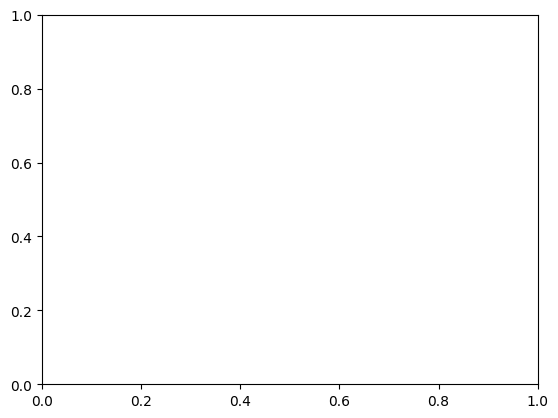

In [85]:
data = {}

data["Scenario A"] = {}
data["Scenario B"] = {}
data["Scenario C"] = {}

data["Scenario A"]["RPI-BLT"] = apply_WLS_estimator(constants.SCENARIO_A_PATH + "RPI/RSS_BLT_Dataset/")
a_rmse_blt = calculate_rmse(data["Scenario A"]["RPI-BLT"] )
print("a_rmse_blt:", a_rmse_blt)
data["Scenario A"]["RPI-WiFi"] = apply_WLS_estimator(constants.SCENARIO_A_PATH + "RPI/RSS_WiFi_Dataset/")
a_rmse_wifi = calculate_rmse(data["Scenario A"]["RPI-WiFi"])
print("a_rmse_wifi:", a_rmse_wifi)
data["Scenario A"]["RPI-Hybrid"] = apply_WLS_hybrid_estimator(constants.SCENARIO_A_PATH)
a_rmse_hybrid = calculate_rmse(data["Scenario A"]["RPI-Hybrid"])
print("a_rmse_hybrid:", a_rmse_hybrid)

data["Scenario B"]["RPI-BLT"] = apply_WLS_estimator(constants.SCENARIO_B_PATH + "RPI/RSS_BLT_Dataset/")
b_rmse_blt = calculate_rmse(data["Scenario B"]["RPI-BLT"])
print("b_rmse_blt:", b_rmse_blt)
data["Scenario B"]["RPI-WiFi"] = apply_WLS_estimator(constants.SCENARIO_B_PATH + "RPI/RSS_WiFi_Dataset/")
b_rmse_wifi = calculate_rmse(data["Scenario B"]["RPI-WiFi"])
print("b_rmse_wifi:", b_rmse_wifi)
data["Scenario B"]["RPI-Hybrid"] = apply_WLS_hybrid_estimator(constants.SCENARIO_B_PATH)
b_rmse_hybrid = calculate_rmse(data["Scenario B"]["RPI-Hybrid"])
print("b_rmse_hybrid:", b_rmse_hybrid)

data["Scenario C"]["RPI-BLT"] = apply_WLS_estimator(constants.SCENARIO_C_PATH + "RPI/RSS_BLT_Dataset/")
c_rmse_blt = calculate_rmse(data["Scenario C"]["RPI-BLT"])
print("c_rmse_blt:", c_rmse_blt)
data["Scenario C"]["RPI-WiFi"] = apply_WLS_estimator(constants.SCENARIO_C_PATH + "RPI/RSS_WiFi_Dataset/")
c_rmse_wifi = calculate_rmse(data["Scenario C"]["RPI-WiFi"])
print("c_rmse_wifi:", c_rmse_wifi)
data["Scenario C"]["RPI-Hybrid"] = apply_WLS_hybrid_estimator(constants.SCENARIO_C_PATH)
c_rmse_hybrid = calculate_rmse(data["Scenario C"]["RPI-Hybrid"])
print("c_rmse_hybrid:", c_rmse_hybrid)
# np.set_printoptions(suppress=True)
# pprint.pprint(data)
# for configuration in data["Scenario B"]["RPI-Hybrid"]["Estimated"]:
#     point = data["Scenario B"]["RPI-Hybrid"]["Estimated"][configuration]["Target Coordinates"]
    # pprint.pprint(point)

plot_date(
    "Scenario A - Actual vs. Estimated Target Coordinates",
    data["Scenario A"],
    (-17, 17),
    (-17, 17)
)

plot_data(
    "Scenario B - Actual vs. Estimated Target Coordinates",
    data["Scenario B"],
    (-18, 18),
    (-12, 17)
)

plot_data(
    "Scenario C - Actual vs. Estimated Target Coordinates",
    data["Scenario C"],
    (-13, 13),
    (-17, 17)
)